# Transmitter side implementation: OFDM in 5G Networks

Orthogonal Frequency Division Multiplexing (**OFDM**) is a modulation technique used in wireless communication systems to transmit data over radio waves. Following are a few features of OFDM technology: 


1. **Orthogonal Frequencies**: OFDM divides the available spectrum into multiple narrowband subcarriers that are orthogonal to each other. Orthogonality means that these subcarriers do not interfere with each other, even though they occupy the same frequency range.
2. **Frequency Division Multiplexing (FDM)**: Each subcarrier is modulated with data, and multiple subcarriers are transmitted simultaneously. This allows for higher data rates compared to traditional single-carrier modulation schemes.
3. **Guard Intervals**: OFDM incorporates guard intervals between symbols to mitigate the effects of multipath interference. These guard intervals help in maintaining orthogonality between subcarriers even in the presence of channel distortions.
4. **Efficiency**: OFDM is highly efficient in utilizing available spectrum, allowing for high data rates and robustness against frequency-selective fading and interference.
5. **MIMO and Beamforming**: OFDM is often used in conjunction with Multiple Input Multiple Output (MIMO) and beamforming techniques in 5G networks to further enhance spectral efficiency and coverage.

OFDM is widely used in various wireless communication standards such as Wi-Fi, LTE (Long-Term Evolution),
WiMAX, and 5G due to its ability to provide high-speed data transmission, robustness to interference,
and efficient spectrum utilization.

## 4.1 Import Libraries
### 4.1 Import Python and SDR Libraries

In [1]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))


%matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import numpy as np
import adi

import matplotlib.patches as patches
import matplotlib.animation as animation

### 4.1 Import 5G Toolkit Libraries 

In [2]:

import sys
sys.path.append("../../../../")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters


## 4.1 Emulation Parameters

In [3]:

# System Parameters
center_frequency    = 1e9     # Carrier frequency for signal transmission

# OFDM Parameters
Bandwidth           = 5*10**6 # bandwidth
fftSize             = 1024    # FFT-size for OFDM
subcarrier_spacing  = 15000   # Subcarrier spacing
numOFDMSymbols      = 14      # Number of OFDM symbols considered for emulation | 1 slot
sample_rate         = fftSize*subcarrier_spacing # sample rate required by OFDM and DAC/ADC of SDR

# Pulse Shaping
numSamplesPerSymbol = 1


# number of samples returned per call to rx()
buffer_size         = int(4*fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols)


## 4.1 Transmitter Implementation

## 4.1 Generate the SSB Grid for synchronization

In [4]:
nSymbolFrame= 140*int(subcarrier_spacing/15000);   # Number of OFDM symbols per frame (Its a function of subcarrier spacing)

## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing, fftsize = fftSize)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff          # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
fftsize     = tfParams.fftsize       # FFT-size for OFDM
lengthCP    = tfParams.lengthCP      # CP length
#___________________________________________________________________

#### Generate MIB Information
lamda                           = 3e8/center_frequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(center_frequency, nSCSOffset, ssbSubCarrierOffset = 0)

systemFrameNumber               = ssbParameters.systemFrameNumber 
subCarrierSpacingCommon         = ssbParameters.subCarrierSpacingCommon 
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset 
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition 
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset 
choiceBit                       = ssbParameters.choiceBit 
ssbType                         = ssbParameters.ssbType 
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit 
cellBarred                      = ssbParameters.cellBarred 
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection 
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

nFrames                         = 0.5
Nsc_ssb                         = 240  # Numbers of subcarriers in SSB
Nsymb_ssb                       = 4    # Numbers of OFDM symbols in SSB

## 4.1 PSS, SSS, PBCH, DMRS Generation

In [5]:
N_ID2        = np.random.randint(3)  # N_ID2 can take values of 0,1 and 2.

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()    # PSS sequence.

N_ID1        = np.random.randint(336)  # N_ID1 can take values ranging from 0 to 335.
N_ID         = 3*N_ID1 + N_ID2         # Calculating Physical Cell ID.

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2)
sssSequence  = sssObject()            # SSS sequence.

# Generate DMRS sequence
dmrsLen      = 144                    # Length of DMRS sequence.
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
dmrsSequence = dmrsObject(dmrsLen)    # DMRS sequence.


# Generate PBCH symbols
pbchObject   = PBCH(center_frequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()          # PBCH payload symbol (QPSK modulated)

## 4.1 SSB Generation

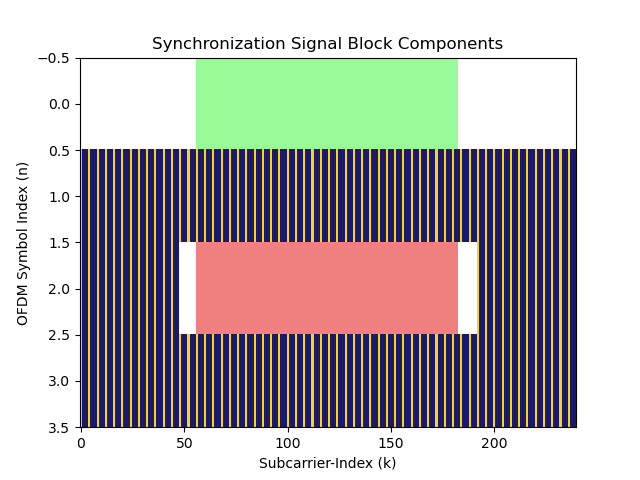

In [6]:
## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)  # generating SSB using PSS,SSS, PBCH payload and DMRS.

## Loading SSB to Resource Grid

ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1 

ssbRGobject    = ResourceMapperSSB(ssbType, center_frequency, isPairedBand, withSharedSpectrumChannelAccess)

ssbGrid = ssbRGobject(ssb[0], ssbPositionInBurst, offsetInSubcarriers = ssbSubCarrierOffset,
                      offsetInRBs = 0, numRBs = nRB)[0:14]        # SSB Grid of size 14 X numbers of RBs x 12.
fig, ax = ssbObject.displayGrid(option=1)

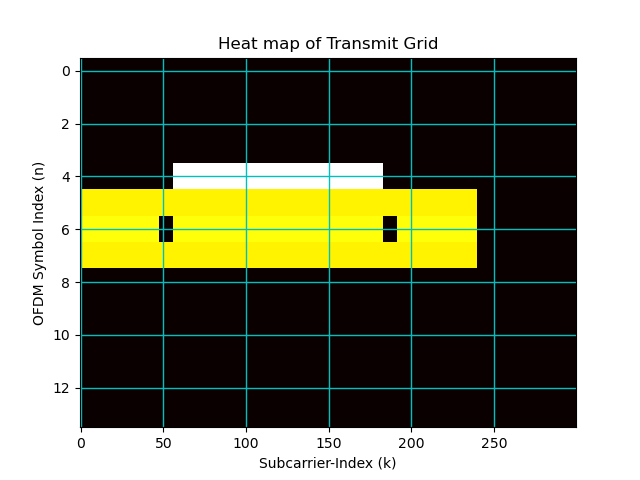

In [7]:
# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(ssbGrid), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## 4.1 Generate transmission Grid

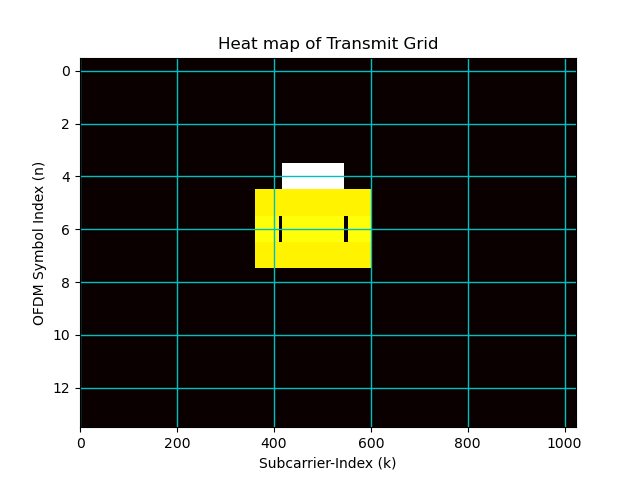

In [8]:
firstSymbolIndex   = int(2)
numofGuardCarriers = (int((fftSize - Neff)/2), int((fftSize - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)

X = np.zeros((numOFDMSymbols, fftSize), dtype= np.complex64)
X[:, firstSCIndex:firstSCIndex+ssbGrid.shape[-1]] = ssbGrid

# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(X), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## 4.1 OFDM Modulation: Transmitted SSB

![](OFDMTx.png)

In [9]:
## OFDM Modulation at Transmitter
#####################################
modulator = OFDMModulator(lengthCP[1])
x_time    = modulator(X).flatten()

In [10]:
numofGuardCarriers, ssbGrid.shape

((362, 362), (14, 300))

## 4.1 SDR-Setup Configurations

In [11]:

# SDR setup
sdr             = adi.Pluto("ip:192.168.2.1")       # Create object of SDR setup object and configure the IP of SDR connect to the system
sdr.sample_rate = int(sample_rate)                  # Sets the sample rate for the ADC/DAC of the SDR.

# Config Tx
sdr.tx_rf_bandwidth         = int(sample_rate)      # Set the bandwidth of the transmit filter | Can be set same as the sample rate
# For Pluto SDR, tx_rf_bandwidth should be between 200 kHz and 56 MHz.
sdr.tx_lo                   = int(center_frequency) # Sets the transmitter local oscillator frequency. The carrier is used to modulate/up-convert the analog information signal.
# For Pluto SDR, tx_lo can take a value between 325 MHz to 3.8 GHz.
sdr.tx_hardwaregain_chan0   = 0                     # Sets the gain (dB) of the transmitter power amplifier. The higher the value the more the power radiated by antenna. 
# For Pluto SDR, tx_hardwaregain_chan0 can take values between -90 to 0.



## 4.1 Transmission

In [12]:

# Start the transmitter
sdr.tx_cyclic_buffer = True          # Enable cyclic buffers
sdr.tx(1.3*2**17*(x_time.repeat(1))) # start transmitting


In [13]:
#np.abs(1.4*2**17*(x_time.repeat(1))).max(), np.abs(x_time).min()